In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kddcup-data-gz/kddcup.data.corrected


In [2]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt


In [1]:
# Define column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/kddcup-data-gz/kddcup.data.corrected', header=None, names=columns)

In [6]:



# # Convert to DataFrame
# columns = [
#     'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
#     'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
#     'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
#     'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
#     'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
#     'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
#     'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
#     'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
#     'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
#     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
# ]
# df = pd.DataFrame([line.split(',') for line in data], columns=columns)

In [4]:
# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns

In [5]:
print(cat_cols)

Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')


In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
# Normalize continuous features
continuous_cols = df.columns.drop(cat_cols)
scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

In [8]:
continuous_cols

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [9]:
import pickle


In [11]:
with open("label_encoders.pkl", "wb") as file_obj:
    pickle.dump(label_encoders, file_obj)

In [12]:
with open("scaler.pkl", "wb") as file_obj:
    pickle.dump(scaler, file_obj)

In [13]:
import torch

data_tensor = torch.tensor(df.values, dtype=torch.float32)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Define the diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

    def training_step(self, x, noise):
        predicted_noise = self(x)
        loss = nn.MSELoss()(predicted_noise, noise)
        return loss
    def sample(self, batch_size, num_steps=1000):
        with torch.no_grad():
            # Start with random noise
            x = torch.randn(batch_size, self.net[-1].out_features, device=next(self.parameters()).device)
            for _ in range(num_steps):
                predicted_noise = self(x)
                x = x - 0.01 * predicted_noise  # Reverse diffusion step
            return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
input_dim = data_tensor.shape[1]
print(input_dim)

42


In [17]:
from tqdm import tqdm

In [18]:
# Initialize the model

model = DiffusionModel(input_dim=input_dim).to(device)
# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Create DataLoader
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [20]:

# Fonction pour calculer l'accuracy (similarité des distributions)
def compute_accuracy(model, data_loader):
    model.eval()
    generated_data = []
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0]
            generated_batch = model.sample(batch_size=x.size(0)).cpu().numpy()
            generated_data.append(generated_batch)
    generated_data = np.concatenate(generated_data, axis=0)
    
    # Calculer une métrique de similarité (exemple : corrélation)
    real_data = data_loader.dataset[:][0].cpu().numpy()
    correlation = np.corrcoef(real_data.flatten(), generated_data.flatten())[0, 1]
    return correlation


In [23]:

best_val_loss = np.inf
epochs_without_improvement = 0
train_losses = []
val_losses = []
accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(dataloader, desc=f"the epoch {epoch+1}/{num_epochs} of training" ) :
        
        x = batch[0].to(device)  # Move data to GPU
        noise = torch.randn_like(x).to(device)  # Move noise to GPU
        noisy_x = x + 0.1 * noise  # Corrupt the data with noise
        loss = model.training_step(noisy_x, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculer l'accuracy
    # accuracy = compute_accuracy(model, dataloader)

    # Enregistrer les métriques
    train_losses.append(train_loss / len(dataloader))
    # accuracies.append(accuracy)

    # Afficher les métriques
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}")
    

the epoch 1/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 425.47it/s]


Epoch [1/50], Train Loss: 0.0427


the epoch 2/50 of training: 100%|██████████| 38269/38269 [01:30<00:00, 423.96it/s]


Epoch [2/50], Train Loss: 0.0391


the epoch 3/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 427.28it/s]


Epoch [3/50], Train Loss: 0.0375


the epoch 4/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.73it/s]


Epoch [4/50], Train Loss: 0.0367


the epoch 5/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.12it/s]


Epoch [5/50], Train Loss: 0.0360


the epoch 6/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 431.90it/s]


Epoch [6/50], Train Loss: 0.0356


the epoch 7/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 433.35it/s]


Epoch [7/50], Train Loss: 0.0352


the epoch 8/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 431.39it/s]


Epoch [8/50], Train Loss: 0.0348


the epoch 9/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.73it/s]


Epoch [9/50], Train Loss: 0.0346


the epoch 10/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 434.05it/s]


Epoch [10/50], Train Loss: 0.0344


the epoch 11/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.31it/s]


Epoch [11/50], Train Loss: 0.0342


the epoch 12/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 429.77it/s]


Epoch [12/50], Train Loss: 0.0340


the epoch 13/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 427.80it/s]


Epoch [13/50], Train Loss: 0.0337


the epoch 14/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.13it/s]


Epoch [14/50], Train Loss: 0.0335


the epoch 15/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 433.55it/s]


Epoch [15/50], Train Loss: 0.0332


the epoch 16/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 431.07it/s]


Epoch [16/50], Train Loss: 0.0329


the epoch 17/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.20it/s]


Epoch [17/50], Train Loss: 0.0326


the epoch 18/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.50it/s]


Epoch [18/50], Train Loss: 0.0324


the epoch 19/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 429.08it/s]


Epoch [19/50], Train Loss: 0.0322


the epoch 20/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 426.91it/s]


Epoch [20/50], Train Loss: 0.0320


the epoch 21/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.25it/s]


Epoch [21/50], Train Loss: 0.0318


the epoch 22/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.65it/s]


Epoch [22/50], Train Loss: 0.0316


the epoch 23/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 428.26it/s]


Epoch [23/50], Train Loss: 0.0315


the epoch 24/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.82it/s]


Epoch [24/50], Train Loss: 0.0313


the epoch 25/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.76it/s]


Epoch [25/50], Train Loss: 0.0312


the epoch 26/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 429.20it/s]


Epoch [26/50], Train Loss: 0.0311


the epoch 27/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 431.29it/s]


Epoch [27/50], Train Loss: 0.0310


the epoch 28/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.73it/s]


Epoch [28/50], Train Loss: 0.0309


the epoch 29/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.82it/s]


Epoch [29/50], Train Loss: 0.0308


the epoch 30/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 429.78it/s]


Epoch [30/50], Train Loss: 0.0307


the epoch 31/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.67it/s]


Epoch [31/50], Train Loss: 0.0307


the epoch 32/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 434.45it/s]


Epoch [32/50], Train Loss: 0.0306


the epoch 33/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 429.90it/s]


Epoch [33/50], Train Loss: 0.0306


the epoch 34/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.70it/s]


Epoch [34/50], Train Loss: 0.0306


the epoch 35/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 434.55it/s]


Epoch [35/50], Train Loss: 0.0305


the epoch 36/50 of training: 100%|██████████| 38269/38269 [01:27<00:00, 436.05it/s]


Epoch [36/50], Train Loss: 0.0305


the epoch 37/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 434.74it/s]


Epoch [37/50], Train Loss: 0.0304


the epoch 38/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.13it/s]


Epoch [38/50], Train Loss: 0.0304


the epoch 39/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 431.52it/s]


Epoch [39/50], Train Loss: 0.0304


the epoch 40/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 433.04it/s]


Epoch [40/50], Train Loss: 0.0303


the epoch 41/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.36it/s]


Epoch [41/50], Train Loss: 0.0303


the epoch 42/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.46it/s]


Epoch [42/50], Train Loss: 0.0303


the epoch 43/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.42it/s]


Epoch [43/50], Train Loss: 0.0303


the epoch 44/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 430.00it/s]


Epoch [44/50], Train Loss: 0.0302


the epoch 45/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 431.48it/s]


Epoch [45/50], Train Loss: 0.0302


the epoch 46/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.58it/s]


Epoch [46/50], Train Loss: 0.0302


the epoch 47/50 of training: 100%|██████████| 38269/38269 [01:29<00:00, 429.81it/s]


Epoch [47/50], Train Loss: 0.0301


the epoch 48/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.58it/s]


Epoch [48/50], Train Loss: 0.0301


the epoch 49/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.22it/s]


Epoch [49/50], Train Loss: 0.0301


the epoch 50/50 of training: 100%|██████████| 38269/38269 [01:28<00:00, 432.64it/s]

Epoch [50/50], Train Loss: 0.0301


In [24]:
torch.save(model.state_dict(), "diffusion_model.pth")

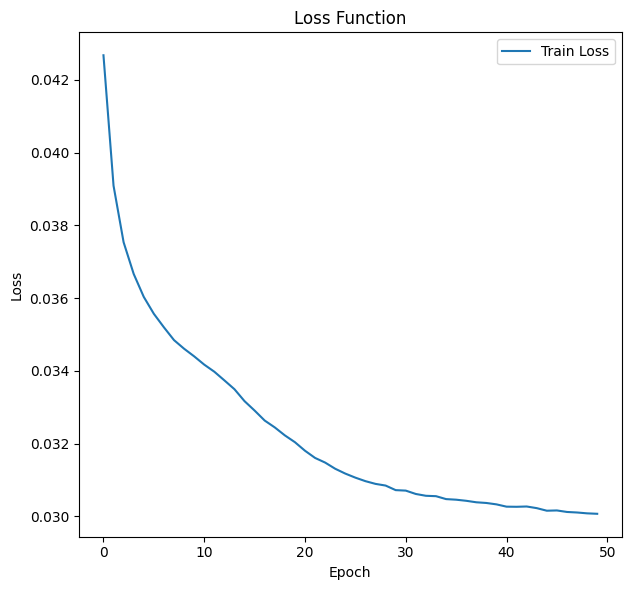

In [25]:
# Tracer les graphiques
plt.figure(figsize=(12, 6))
# Graphique de la perte
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
# plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.legend()

# # Graphique de l'accuracy
# plt.subplot(1, 2, 2)
# plt.plot(accuracies, label="Accuracy", color="green")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Accuracy")
# plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Generate new samples
batch_size = 128
generated_data = model.sample(batch_size=batch_size)

# Convertir les données générées en DataFrame
generated_data_np = generated_data.cpu().numpy()
generated_df = pd.DataFrame(generated_data_np, columns=columns)

# Inverse scaling pour les caractéristiques continues
generated_df[continuous_cols] = scaler.inverse_transform(generated_df[continuous_cols])

# Décodage des caractéristiques catégorielles
for col in cat_cols:
    encoder = label_encoders[col]
    # Limiter les valeurs générées aux classes valides
    valid_classes = np.arange(len(encoder.classes_))
    generated_df[col] = np.round(generated_df[col]).astype(int)
    generated_df[col] = np.clip(generated_df[col], valid_classes.min(), valid_classes.max())
    # Décodage des valeurs
    generated_df[col] = encoder.inverse_transform(generated_df[col])

# Afficher les données générées
print(generated_df.head())

       duration protocol_type service flag     src_bytes     dst_bytes  \
0  1.231117e+02           tcp     aol  REJ  1.581422e+06 -6.189440e+06   
1  5.150073e+02           tcp     IRC  REJ -1.396327e+06 -8.099774e+06   
2  5.150091e+02           tcp     IRC  REJ -1.396266e+06 -8.099712e+06   
3  5.150084e+02           tcp     IRC  REJ -1.396457e+06 -8.099898e+06   
4  1.522122e+09          icmp     IRC   SH  3.235530e+11 -7.599659e+12   

          land  wrong_fragment         urgent            hot  ...  \
0    -0.004132        0.021255       0.040360       0.083334  ...   
1    -0.004884        0.018653       0.005334       0.241474  ...   
2    -0.004884        0.018653       0.005334       0.241471  ...   
3    -0.004884        0.018653       0.005334       0.241480  ...   
4  1471.537720     8043.841797  144118.687500 -122638.570312  ...   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0        1.040919e+01                0.069288                0.0739